In [1]:
using PyPlot, DataFrames
using Statistics, LsqFit

I like to store the adjacency list in memory. That's typically faster than computing it on the fly since modulo is an expensive operation.

In [2]:
function lattice_adj(W, L)    
    adj = fill(fill((0,0),4), W, L)
    for w in 1:W, l in 1:L
        adj[w,l] = [
            (mod1(w+1, W), l),
            (mod1(w-1+W, W), l),
            (w, mod1(l+1, L)),
            (w, mod1(l-1+L, L))
        ]
    end
    return adj
end

lattice_adj (generic function with 1 method)

In [3]:
Adj = typeof(lattice_adj(2,2))
SiteSet = Set{Tuple{Int,Int}}

Set{Tuple{Int64, Int64}}

# "Percolation"

In [9]:
function flip_small_cluster(conf::Matrix{Int}, adj::Adj)
    W,L = size(conf)
    
    w, l = rand(1:W), rand(1:L)
    all = vcat([(w,l)], adj[w,l])
    
    s = sum([conf[wl...] for wl in all]) > 0 ? +1 : -1
    for wl in all
        conf[wl...] = s
    end
end

flip_small_cluster (generic function with 1 method)

Plot a single time trace.

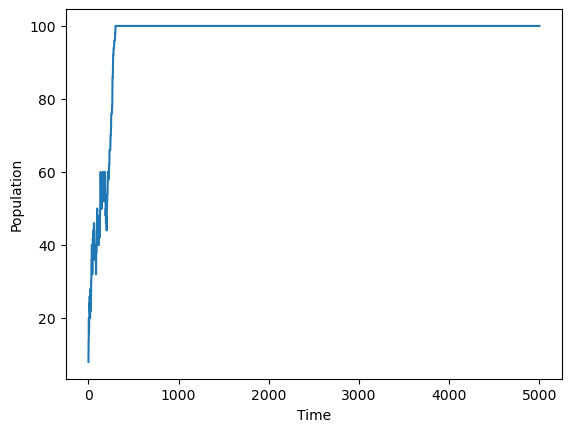

PyObject Text(24.000000000000007, 0.5, 'Population')

In [10]:
let
    L = 10
    adj = lattice_adj(L, L)
    ising_spins = rand([-1,1], L, L)
    
    Nmc = 5000
    y = zeros(Nmc)
    
    for step in 1:Nmc
        flip_small_cluster(ising_spins, adj)
        y[step] = sum(ising_spins)
    end
    
    plot(y)
    
    xlabel("Time")
    ylabel("Population")
end

Run until the population has made a decision, then return how long that took.

In [11]:
function conv_time(L, p)
    adj = lattice_adj(L, L)
    ising_spins = fill(-1, L,L)
    
    for w in 1:L, l in 1:L
        ising_spins[w,l] = rand() < p ? +1 : -1
    end
    
    step_count = 0
    while abs(sum(ising_spins)) < L^2
        flip_small_cluster(ising_spins, adj)
        step_count += 1
    end
    
    return step_count
end

conv_time (generic function with 1 method)

Let's check that the time is maximal at $p=0.5$.

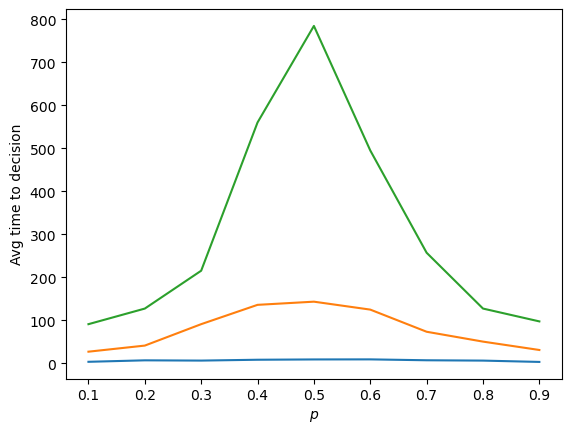

PyObject Text(24.000000000000007, 0.5, 'Avg time to decision')

In [12]:
let
    df = DataFrame(L=Int[], p=Float64[], t_avg=Float64[])
    for L in [4, 8, 12], p in 0.1:0.1:0.9
        samples = [conv_time(L, p) for run in 1:50]
        push!(df, [L, p, mean(samples)])
    end
    
    for subdf in groupby(df, :L)
        plot(subdf[!,:p], subdf[!,:t_avg])
    end
    
    xlabel(L"p")
    ylabel("Avg time to decision")
end

For any $0 < p < 1$, the time diverges as a power-law.

fit.param = [-3.550532460064857, 4.203861769645479]
  7.789338 seconds (17.66 M allocations: 1.111 GiB, 8.31% gc time, 3.84% compilation time)

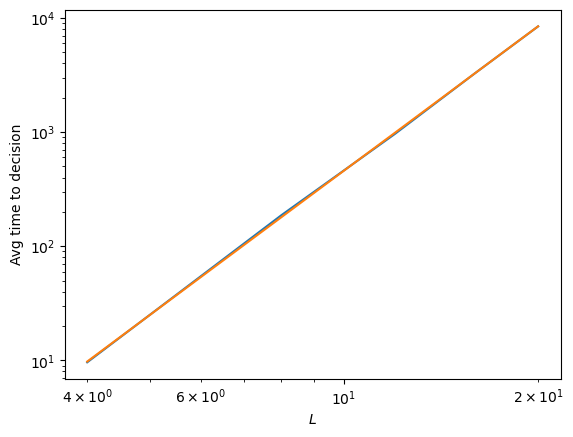

PyObject Text(24.000000000000007, 0.5, 'Avg time to decision')

In [8]:
@time begin
    df = DataFrame(L=Int[], p=Float64[], t_avg=Float64[])
    for L in 4:4:20, p in 0.5
        samples = [conv_time(L, p) for run in 1:50]
        push!(df, [L, p, mean(samples)])
    end
    
    @. model(x,p) = p[1] + x*p[2]
    
    for subdf in groupby(df, :p)
        plot(subdf[!,:L], subdf[!,:t_avg])
        x = log.(subdf[!,:L])
        y = log.(subdf[!,:t_avg])
        fit = curve_fit(model, x, y, [1.0, 2.0])
        @show fit.param
        plot(subdf[!,:L], exp.(model(x, fit.param)))
    end
    yscale("log")
    xscale("log")
    
    xlabel(L"L")
    ylabel("Avg time to decision")
end